In [2]:
import xarray as xr
import numba
from Algorithms.fetchfields import *

In [3]:
ds = xr.open_dataset("http://thredds.met.no/thredds/dodsC/meps25epsarchive/2019/12/09/meps_extracted_2_5km_20191209T06Z.nc")
ds1 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/mepsarchive/2019/12/09/cmeps_det_2_5km_20191209T06Z.nc")



In [25]:
ds["upward_air_velocity_pl"].pressure.values

array([  50.,  100.,  150.,  200.,  250.,  300.,  400.,  500.,  700.,
        800.,  850.,  925., 1000.], dtype=float32)

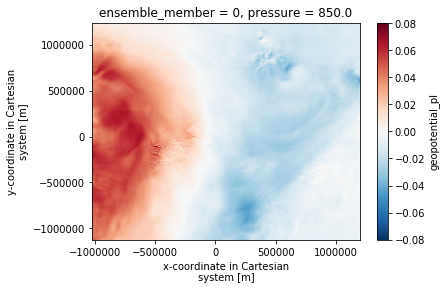

In [41]:
((ds["geopotential_pl"].sel(pressure=850,ensemble_member=0).isel(time=29) - ds["geopotential_pl"].sel(pressure=850,ensemble_member=0).isel(time=30))/3600).plot()



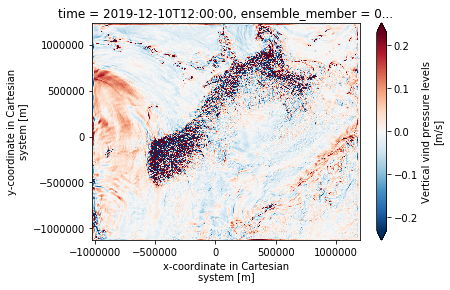

In [36]:
ds["upward_air_velocity_pl"].sel(pressure=850,ensemble_member=0).isel(time=30).plot(robust = 1)


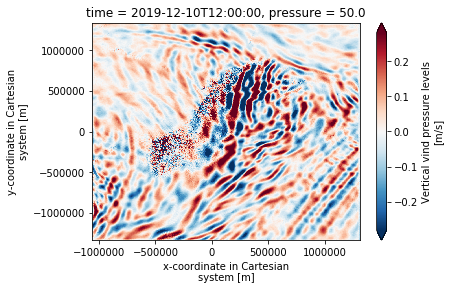

In [40]:
ds1["upward_air_velocity_pl"].sel(pressure=50).isel(time=30).plot(robust = 1)


In [ ]:
geo_pl, geo_sf, airtemp_pl, rhs_pl, lowcloud, prec = fetchfields(ds,0)

In [ ]:
from Algorithms.HelicopterTriggerIndex import *

In [ ]:
def temperature_max_band_from_b_to_c(b,c):
    """
    NOTE: C < B
    Gives high risk (1 or 100%) for temperatures in [c,b] gives [0,1] for [a,b]
    and [1,0] for [c,d] (linear mapping)
    """
    # Define a and d for linear mapping
    a = b + 1
    d = c - 1
    @numba.jit
    def f(T):
        # Risk is 0 if not inside band or outliers
        temperature = 0.
        # In higher band, increasing risk
        if T > b and T < a:
            # Already checked if valued between a and b, won't get problems from abs()
            temperature = abs(abs(T) - abs(a))
        # In main band of temperatures
        elif T >= c and T <= b:
            temperature = 1.
        # In lower band, decreasing risk
        elif T > d and T < c:
            temperature = abs(abs(T) - abs(d))
        return temperature
    return f
HTI = HelicopterTriggerIndex([temperature_max_band_from_b_to_c(5,-5)])


In [ ]:
result = np.zeros_like(airtemp_pl.sel(pressure = 925).values)


In [ ]:
temps = airtemp_pl.sel(pressure = 925).values - 273.15
result.shape

In [ ]:
#For treigt å loope i python. Enten gå over til fortran eller bruk arrays.
first_slice = np.where(temps > -1,1,0)
second_slice = np.where(temps < 1,1,0)
new_slice = np.where(first_slice == second_slice,1,0)
new_slice

In [ ]:
result[np.where(new_slice)] = 1
result

In [ ]:
ds